# JointMatch Reimagined: Tiny ImageNet SSL (Kaggle Optimized)

This notebook implements the JointMatch semi-supervised learning algorithm for image classification on the Tiny ImageNet dataset using a custom PyTorch training loop, optimized for Kaggle.

**Core Idea:** Leverage two models teaching each other with adaptive thresholds, without relying on external training frameworks like Ignite.

**References:**
*   **JointMatch Paper:** Zou, H. P., & Caragea, C. (2023). JointMatch: A Unified Approach for Diverse and Collaborative Pseudo-Labeling to Semi-Supervised Text Classification. *EMNLP 2023*.

## 1. Setup & Installs

In [ ]:
# install necessary packages (efficientnet and dataset downloader)
print("installing dependencies...")
!pip install -q opendatasets efficientnet-pytorch tqdm
print("dependencies installed.")

# --- verification ---
try:
    import torch
    import torchvision
    print(f"pytorch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    print(f"cuda available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"cuda version detected by pytorch: {torch.version.cuda}")
        print(f"device name: {torch.cuda.get_device_name(0)}")
except importerror as e:
    print(f"error importing torch/torchvision: {e}. ensure pytorch is installed.")
except exception as e:
    print(f"an error occurred during verification: {e}")

Installing dependencies...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2

## 2. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
import random
import zipfile
import shutil
import warnings
import copy
from math import floor, ceil
from sklearn.model_selection import train_test_split # Still useful for potential splits
from itertools import cycle
import time
import glob
from tqdm.notebook import tqdm # Progress bar

import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
from efficientnet_pytorch import EfficientNet

warnings.filterwarnings('ignore')

## 3. Configuration

In [ ]:
# basic setup
SEED = 42
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"using device: {device}")

# data parameters
DATA_DIR_KAGGLE = '/kaggle/input/tiny-imagenet-200/tiny-imagenet-200'
DATA_DIR_MANUAL = './tiny-imagenet-200'
MANUAL_DOWNLOAD = True
DATA_DIR = DATA_DIR_MANUAL if MANUAL_DOWNLOAD else DATA_DIR_KAGGLE
NUM_CLASSES = 200
IMG_SIZE = 64
VAL_IMAGES_PER_CLASS = 50

# semi-supervised learning parameters
NUM_LABELED_PER_CLASS = 10
TOTAL_TRAIN_IMAGES_PER_CLASS = 500

# jointmatch hyperparameters
ema_decay = 0.999
base_threshold = 0.95
disagreement_weight = 0.7
unlabeled_loss_weight = 1.0

# training hyperparameters
batch_size = 64
unlabeled_ratio = 7
labeled_batch_size = batch_size // (unlabeled_ratio + 1)
unlabeled_batch_size = batch_size - labeled_batch_size
print(f"total batch size: {batch_size}")
print(f"  labeled batch size: {labeled_batch_size}")
print(f"  unlabeled batch size: {unlabeled_batch_size}")
lr = 3e-4
num_epochs = 100
num_labeled_total = NUM_LABELED_PER_CLASS * NUM_CLASSES
steps_per_epoch = ceil(num_labeled_total / labeled_batch_size)
print(f"steps per epoch (based on labeled data): {steps_per_epoch}")
gradient_accumulation_steps = 1

# saving/loading parameters
KAGGLE_WORKING_DIR = "/kaggle/working/"
output_dir = os.path.join(KAGGLE_WORKING_DIR, "jointmatch_output")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
best_model_path = os.path.join(output_dir, "best_model.pth")
save_every_epochs = 5

# helper functions
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

# create output directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

Using device: cuda
Total Batch Size: 64
  Labeled Batch Size: 8
  Unlabeled Batch Size: 56
Steps per epoch (based on labeled data): 250


## 4. Data Loading & Preprocessing

In [ ]:
# --- download and extract data (if MANUAL_DOWNLOAD is True) ---
if MANUAL_DOWNLOAD:
    zip_file_path = './tiny-imagenet-200.zip'
    if not os.path.exists(DATA_DIR):
        if not os.path.exists(zip_file_path):
            print("downloading tiny imagenet...")
            !wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip -O {zip_file_path}
            print("download complete.")
        else:
            print(f"zip file {zip_file_path} already exists.")

        print("extracting tiny imagenet...")
        try:
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall('.')
            print("data extracted.")
        except zipfile.BadZipFile:
            print(f"error: {zip_file_path} corrupted or not zip. re-download.")
            raise
        except Exception as e:
            print(f"error during extraction: {e}")
            raise
    else:
        print(f"tiny imagenet directory '{DATA_DIR}' already exists.")
elif not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"kaggle input directory '{DATA_DIR}' not found. check path.")
else:
    print(f"using tiny imagenet data from kaggle input: {DATA_DIR}")

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# --- organize validation folder ---
val_img_dir = os.path.join(VAL_DIR, 'images')
annotations_file = os.path.join(VAL_DIR, 'val_annotations.txt')
organized_val_dir_exists = False
if os.path.isdir(VAL_DIR):
    if not os.path.exists(val_img_dir) and not os.path.exists(annotations_file):
        subdirs = [d for d in os.listdir(VAL_DIR) if os.path.isdir(os.path.join(VAL_DIR, d))]
        if len(subdirs) == NUM_CLASSES:
            organized_val_dir_exists = True
            print("validation folder appears already organized.")

if not organized_val_dir_exists and os.path.exists(val_img_dir) and os.path.exists(annotations_file):
    print("organizing validation folder...")
    try:
        val_data = pd.read_csv(annotations_file, sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
        for index, row in tqdm(val_data.iterrows(), total=len(val_data), desc="organizing val"):
            img_class = row['Class']
            img_file = row['File']
            class_dir = os.path.join(VAL_DIR, img_class)
            os.makedirs(class_dir, exist_ok=True)
            source_path = os.path.join(val_img_dir, img_file)
            dest_path = os.path.join(class_dir, img_file)
            if os.path.exists(source_path):
                shutil.move(source_path, dest_path)
        if os.path.exists(val_img_dir) and not os.listdir(val_img_dir):
            os.rmdir(val_img_dir)
        os.remove(annotations_file)
        print("validation folder organized.")
    except Exception as e:
        print(f"error organizing validation folder: {e}")
elif not organized_val_dir_exists:
    print("warning: validation folder not organized and source files missing. cannot organize.")

# --- define data augmentations ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

weak_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

strong_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=10),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

val_transform = T.Compose([
    T.Resize(IMG_SIZE + 8),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# --- create datasets ---
try:
    full_train_dataset = datasets.ImageFolder(TRAIN_DIR)
except FileNotFoundError:
    print(f"error: training directory '{TRAIN_DIR}' not found.")
    raise
except Exception as e:
    print(f"error loading training dataset: {e}")
    raise

# split training data
targets = np.array(full_train_dataset.targets)
labeled_indices = []
unlabeled_indices = []
for i in range(NUM_CLASSES):
    class_indices = np.where(targets == i)[0]
    if len(class_indices) < NUM_LABELED_PER_CLASS:
        print(f"warning: class {i} has {len(class_indices)} samples < {NUM_LABELED_PER_CLASS}. using all as labeled.")
        labeled_indices.extend(class_indices)
    else:
        np.random.shuffle(class_indices)
        labeled_indices.extend(class_indices[:NUM_LABELED_PER_CLASS])
        unlabeled_indices.extend(class_indices[NUM_LABELED_PER_CLASS:])
print(f"total training samples: {len(full_train_dataset)}")
print(f"labeled samples: {len(labeled_indices)}")
print(f"unlabeled samples: {len(unlabeled_indices)}")

# custom dataset wrappers
class LabeledDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

class UnlabeledDataset(Dataset):
    def __init__(self, subset, transform_weak, transform_strong):
        self.subset = subset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong
    def __getitem__(self, index):
        x, _ = self.subset[index]
        return self.transform_weak(x), self.transform_strong(x)
    def __len__(self):
        return len(self.subset)

labeled_subset = Subset(full_train_dataset, labeled_indices)
unlabeled_subset = Subset(full_train_dataset, unlabeled_indices)

labeled_dataset = LabeledDataset(labeled_subset, weak_transform)
unlabeled_dataset = UnlabeledDataset(unlabeled_subset, weak_transform, strong_transform)

# validation dataset
val_loader = None
try:
    val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
    if len(val_dataset) > 0:
        num_workers = 2
        pin_memory = True if use_cuda else False
        val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
        print(f"validation dataset loaded with {len(val_dataset)} samples.")
    else:
        print("warning: validation dataset is empty.")
except FileNotFoundError:
    print(f"error: validation directory '{VAL_DIR}' not found or not organized.")
except Exception as e:
    print(f"error loading validation dataset: {e}")

# --- create training dataloaders ---
num_workers = 2
pin_memory = True if use_cuda else False
labeled_loader = DataLoader(labeled_dataset, batch_size=labeled_batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=unlabeled_batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, drop_last=True)

# create iterators
labeled_iter = cycle(labeled_loader)
unlabeled_iter = cycle(unlabeled_loader)
print("dataloaders created.")

Download complete.
Extracting Tiny ImageNet...
Data extracted.
Organizing validation folder...


Organizing Val:   0%|          | 0/10000 [00:00<?, ?it/s]

Validation folder organized.
Total training samples: 100000
Labeled samples: 2000
Unlabeled samples: 98000
Validation dataset loaded with 10000 samples.
DataLoaders created.


## 5. Model Definition

In [ ]:
# load Load two instances of the EfficientNet model
MODEL_ARCH = 'efficientnet-b0'
print(f"Loading model architecture: {MODEL_ARCH}")
try:
    model_f = EfficientNet.from_pretrained(MODEL_ARCH, num_classes=NUM_CLASSES)
    model_g = EfficientNet.from_pretrained(MODEL_ARCH, num_classes=NUM_CLASSES)
    print(f"Loaded pretrained weights for {MODEL_ARCH}")
except Exception as e:
    print(f"Error loading pretrained model: {e}")
    raise

model_f = model_f.to(device)
model_g = model_g.to(device)

Loading model architecture: efficientnet-b0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 44.8MB/s]


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


## 6. Optimizer & Loss

In [6]:
# Optimizers
optimizer_f = optim.Adam(model_f.parameters(), lr=lr)
optimizer_g = optim.Adam(model_g.parameters(), lr=lr)

# Loss functions
criterion_s = nn.CrossEntropyLoss().to(device) # Supervised loss
criterion_u = nn.CrossEntropyLoss(reduction='none').to(device) # Unlabeled loss (manual reduction)

## 7. Evaluation Function

In [ ]:
def evaluate(model, dataloader, criterion, device, desc="Evaluating"):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # disable gradient calculations
        for inputs, labels in tqdm(dataloader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy

## 8. Training Loop

In [ ]:
print("Starting JointMatch Training...")
start_time = time.time()
best_val_acc = -1.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# initialize EMA probabilities (Needs to be persistent across steps)
ema_p = torch.ones(NUM_CLASSES).to(device) / NUM_CLASSES

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model_f.train()
    model_g.train()

    # track epoch metrics
    epoch_loss_s_f, epoch_loss_u_f, epoch_loss_s_g, epoch_loss_u_g = 0.0, 0.0, 0.0, 0.0
    total_batches = 0
    conf_f_count, conf_g_count, disagree_count = 0, 0, 0
    total_unlabeled_processed = 0

    # use tqdm for the main training loop progress
    pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{num_epochs}")

    for step in pbar:
        # === get Batches ===
        try:
            inputs_l, targets_l = next(labeled_iter)
            inputs_u_w, inputs_u_s = next(unlabeled_iter)
        except StopIteration:
            # should not happen with cycle, but resetting just in case
            labeled_iter = cycle(labeled_loader)
            unlabeled_iter = cycle(unlabeled_loader)
            inputs_l, targets_l = next(labeled_iter)
            inputs_u_w, inputs_u_s = next(unlabeled_iter)

        inputs_l, targets_l = inputs_l.to(device), targets_l.to(device)
        inputs_u_w, inputs_u_s = inputs_u_w.to(device), inputs_u_s.to(device)

        # === supervised Loss ===
        logits_l_f = model_f(inputs_l)
        logits_l_g = model_g(inputs_l)
        loss_s_f = criterion_s(logits_l_f, targets_l)
        loss_s_g = criterion_s(logits_l_g, targets_l)

        # === unlabeled Loss Calculation ===
        with torch.no_grad():
            logits_u_w_f = model_f(inputs_u_w)
            logits_u_w_g = model_g(inputs_u_w)
            probs_u_w_f = F.softmax(logits_u_w_f, dim=1)
            probs_u_w_g = F.softmax(logits_u_w_g, dim=1)

            # update EMA
            avg_probs_u_w = (probs_u_w_f + probs_u_w_g) / 2.0
            batch_p = avg_probs_u_w.mean(dim=0)
            ema_p = ema_decay * ema_p + (1 - ema_decay) * batch_p
            ema_p = ema_p.detach()

            # adaptive Thresholds
            max_ema_p = torch.max(ema_p)
            normalized_ema_p = ema_p / (max_ema_p + 1e-8) # add epsilon
            adaptive_thresholds = base_threshold * normalized_ema_p
            min_threshold = 1.0 / NUM_CLASSES
            adaptive_thresholds = torch.max(adaptive_thresholds, torch.tensor(min_threshold).to(device))

            # pseudo-labels & Masks
            max_probs_f, pseudo_labels_hard_f = torch.max(probs_u_w_f, dim=1)
            max_probs_g, pseudo_labels_hard_g = torch.max(probs_u_w_g, dim=1)
            thresholds_f = adaptive_thresholds.gather(0, pseudo_labels_hard_f)
            thresholds_g = adaptive_thresholds.gather(0, pseudo_labels_hard_g)
            mask_f = max_probs_f.ge(thresholds_f).float()
            mask_g = max_probs_g.ge(thresholds_g).float()

            # disagreement Weights
            disagree_mask = (pseudo_labels_hard_f != pseudo_labels_hard_g).float()
            sample_weights = disagreement_weight * disagree_mask + (1.0 - disagreement_weight) * (1.0 - disagree_mask)

            # track stats
            num_conf_f = mask_f.sum().item()
            num_conf_g = mask_g.sum().item()
            num_disagree = disagree_mask.sum().item()
            conf_f_count += num_conf_f
            conf_g_count += num_conf_g
            disagree_count += num_disagree
            total_unlabeled_processed += inputs_u_w.size(0)

        # === consistency Loss ===
        logits_u_s_f = model_f(inputs_u_s)
        logits_u_s_g = model_g(inputs_u_s)

        loss_u_f_all = criterion_u(logits_u_s_f, pseudo_labels_hard_g)
        loss_u_f = (loss_u_f_all * mask_g * sample_weights).sum() / (num_conf_g + 1e-8)

        loss_u_g_all = criterion_u(logits_u_s_g, pseudo_labels_hard_f)
        loss_u_g = (loss_u_g_all * mask_f * sample_weights).sum() / (num_conf_f + 1e-8)

        loss_u_f = torch.nan_to_num(loss_u_f)
        loss_u_g = torch.nan_to_num(loss_u_g)

        # === total Loss & Backpropagation ===
        total_loss_f = loss_s_f + unlabeled_loss_weight * loss_u_f
        total_loss_g = loss_s_g + unlabeled_loss_weight * loss_u_g

        # normalize loss for accumulation (optional, if steps vary)
        # total_loss_f = total_loss_f / gradient_accumulation_steps
        # total_loss_g = total_loss_g / gradient_accumulation_steps

        # backward pass for F
        optimizer_f.zero_grad()
        total_loss_f.backward()
        # clipping gradients (optional but fir bhi)
        # torch.nn.utils.clip_grad_norm_(model_f.parameters(), max_norm=1.0)
        optimizer_f.step()

        # backward pass for G
        optimizer_g.zero_grad()
        total_loss_g.backward()
        # clipping gradients (optional but fir bhi)
        # torch.nn.utils.clip_grad_norm_(model_g.parameters(), max_norm=1.0)
        optimizer_g.step()

        # --- update Epoch Metrics --- 
        epoch_loss_s_f += loss_s_f.item()
        epoch_loss_u_f += loss_u_f.item()
        epoch_loss_s_g += loss_s_g.item()
        epoch_loss_u_g += loss_u_g.item()
        total_batches += 1

        # update progress bar description
        avg_loss = (total_loss_f.item() + total_loss_g.item()) / 2.0
        pbar.set_postfix(loss=f"{avg_loss:.4f}", 
                         u_f=f"{loss_u_f.item():.4f}", u_g=f"{loss_u_g.item():.4f}")

    # --- end of Epoch --- 
    avg_epoch_loss_s_f = epoch_loss_s_f / total_batches
    avg_epoch_loss_u_f = epoch_loss_u_f / total_batches
    avg_epoch_loss_s_g = epoch_loss_s_g / total_batches
    avg_epoch_loss_u_g = epoch_loss_u_g / total_batches
    avg_epoch_conf_f = conf_f_count / total_unlabeled_processed if total_unlabeled_processed > 0 else 0
    avg_epoch_conf_g = conf_g_count / total_unlabeled_processed if total_unlabeled_processed > 0 else 0
    avg_epoch_disagree = disagree_count / total_unlabeled_processed if total_unlabeled_processed > 0 else 0

    # evaluate on validation set (if available)
    val_loss, val_acc = 0.0, 0.0
    if val_loader:
        # evaluate model_f (or could use model_g or an ensemble)
        val_loss, val_acc = evaluate(model_f, val_loader, criterion_s, device, desc="Validating")
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    else:
        history['val_loss'].append(None)
        history['val_acc'].append(None)

    # optionally evaluate on a subset of training data (labeled part)
    # train_loss_eval, train_acc_eval = evaluate(model_f, labeled_loader, criterion_s, device, desc="Eval Train (Labeled)")
    # history['train_loss'].append(train_loss_eval)
    # history['train_acc'].append(train_acc_eval)
    # ffor simplicity, we'll just log the average training batch losses
    history['train_loss'].append((avg_epoch_loss_s_f + avg_epoch_loss_s_g)/2)
    history['train_acc'].append(None) # Placeholder if not evaluating train acc separately

    epoch_duration = time.time() - epoch_start_time

    print(f"\nEpoch {epoch+1}/{num_epochs} Summary ({epoch_duration:.2f}s):")
    print(f"  Avg Train Loss: S_f={avg_epoch_loss_s_f:.4f}, U_f={avg_epoch_loss_u_f:.4f} | S_g={avg_epoch_loss_s_g:.4f}, U_g={avg_epoch_loss_u_g:.4f}")
    print(f"  Avg Unlabeled Stats: Conf_F={avg_epoch_conf_f:.3f}, Conf_G={avg_epoch_conf_g:.3f}, Disagree={avg_epoch_disagree:.3f}")
    if val_loader:
        print(f"  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
    else:
        print("  Validation: Skipped (no validation data)")

    # --- ccheckpointing --- 
    # save periodic checkpoint
    if (epoch + 1) % save_every_epochs == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_f_state_dict': model_f.state_dict(),
            'model_g_state_dict': model_g.state_dict(),
            'optimizer_f_state_dict': optimizer_f.state_dict(),
            'optimizer_g_state_dict': optimizer_g.state_dict(),
            # noote: ema_p is NOT saved here to avoid issues, training resumes with default ema_p
            'val_loss': val_loss, # Save last validation loss for info
            'val_acc': val_acc
        }, checkpoint_path)
        print(f"  Checkpoint saved to {checkpoint_path}")

    # save best model based on validation accuracy
    if val_loader and val_acc > best_val_acc:
        best_val_acc = val_acc
        # save model F's state dict as the best model
        torch.save({
            'epoch': epoch + 1,
            'model_f_state_dict': model_f.state_dict(),
            'val_acc': best_val_acc
        }, best_model_path)
        print(f"  New best model saved to {best_model_path} (Val Acc: {best_val_acc:.4f})")

    print("-" * 50)

total_training_time = time.time() - start_time
print(f"\nTraining finished. Total duration: {total_training_time/60:.2f} minutes.")

Starting JointMatch Training...


Epoch 1/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 1/100 Summary (58.68s):
  Avg Train Loss: S_f=5.2998, U_f=0.0000 | S_g=5.2951, U_g=0.0000
  Avg Unlabeled Stats: Conf_F=0.000, Conf_G=0.000, Disagree=0.949
  Validation Loss: 4.8814, Validation Acc: 0.0786
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.0786)
--------------------------------------------------


Epoch 2/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 2/100 Summary (55.52s):
  Avg Train Loss: S_f=3.7031, U_f=0.0029 | S_g=3.7028, U_g=0.0233
  Avg Unlabeled Stats: Conf_F=0.000, Conf_G=0.000, Disagree=0.851
  Validation Loss: 4.3673, Validation Acc: 0.1423
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1423)
--------------------------------------------------


Epoch 3/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 3/100 Summary (55.58s):
  Avg Train Loss: S_f=2.4734, U_f=0.5466 | S_g=2.4714, U_g=0.5877
  Avg Unlabeled Stats: Conf_F=0.038, Conf_G=0.036, Disagree=0.757
  Validation Loss: 4.4465, Validation Acc: 0.1316
--------------------------------------------------


Epoch 4/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 4/100 Summary (56.11s):
  Avg Train Loss: S_f=1.4112, U_f=1.0871 | S_g=1.3900, U_g=1.0394
  Avg Unlabeled Stats: Conf_F=0.161, Conf_G=0.160, Disagree=0.660
  Validation Loss: 4.1966, Validation Acc: 0.1547
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1547)
--------------------------------------------------


Epoch 5/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 5/100 Summary (56.40s):
  Avg Train Loss: S_f=0.6548, U_f=1.2122 | S_g=0.6503, U_g=1.2325
  Avg Unlabeled Stats: Conf_F=0.204, Conf_G=0.209, Disagree=0.647
  Validation Loss: 4.2655, Validation Acc: 0.1608
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_5.pth
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1608)
--------------------------------------------------


Epoch 6/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 6/100 Summary (56.17s):
  Avg Train Loss: S_f=0.3407, U_f=1.2346 | S_g=0.3284, U_g=1.2573
  Avg Unlabeled Stats: Conf_F=0.233, Conf_G=0.229, Disagree=0.629
  Validation Loss: 4.2600, Validation Acc: 0.1776
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1776)
--------------------------------------------------


Epoch 7/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 7/100 Summary (57.26s):
  Avg Train Loss: S_f=0.2395, U_f=1.2761 | S_g=0.2296, U_g=1.2181
  Avg Unlabeled Stats: Conf_F=0.244, Conf_G=0.257, Disagree=0.624
  Validation Loss: 4.2864, Validation Acc: 0.1813
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1813)
--------------------------------------------------


Epoch 8/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 8/100 Summary (51.96s):
  Avg Train Loss: S_f=0.1769, U_f=1.3042 | S_g=0.1757, U_g=1.2615
  Avg Unlabeled Stats: Conf_F=0.283, Conf_G=0.293, Disagree=0.610
  Validation Loss: 4.2493, Validation Acc: 0.1900
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1900)
--------------------------------------------------


Epoch 9/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 9/100 Summary (51.81s):
  Avg Train Loss: S_f=0.1651, U_f=1.2575 | S_g=0.1731, U_g=1.2903
  Avg Unlabeled Stats: Conf_F=0.269, Conf_G=0.270, Disagree=0.625
  Validation Loss: 4.5994, Validation Acc: 0.1717
--------------------------------------------------


Epoch 10/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 10/100 Summary (51.63s):
  Avg Train Loss: S_f=0.1675, U_f=1.2965 | S_g=0.1724, U_g=1.3526
  Avg Unlabeled Stats: Conf_F=0.252, Conf_G=0.254, Disagree=0.629
  Validation Loss: 4.4572, Validation Acc: 0.1741
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_10.pth
--------------------------------------------------


Epoch 11/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 11/100 Summary (52.35s):
  Avg Train Loss: S_f=0.1641, U_f=1.3615 | S_g=0.1539, U_g=1.3872
  Avg Unlabeled Stats: Conf_F=0.265, Conf_G=0.267, Disagree=0.637
  Validation Loss: 4.5436, Validation Acc: 0.1826
--------------------------------------------------


Epoch 12/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 12/100 Summary (51.91s):
  Avg Train Loss: S_f=0.1286, U_f=1.3677 | S_g=0.1414, U_g=1.4128
  Avg Unlabeled Stats: Conf_F=0.307, Conf_G=0.300, Disagree=0.642
  Validation Loss: 4.7876, Validation Acc: 0.1779
--------------------------------------------------


Epoch 13/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 13/100 Summary (51.40s):
  Avg Train Loss: S_f=0.1068, U_f=1.3050 | S_g=0.1255, U_g=1.2950
  Avg Unlabeled Stats: Conf_F=0.282, Conf_G=0.297, Disagree=0.630
  Validation Loss: 4.4789, Validation Acc: 0.1847
--------------------------------------------------


Epoch 14/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 14/100 Summary (51.64s):
  Avg Train Loss: S_f=0.1186, U_f=1.2496 | S_g=0.1291, U_g=1.2058
  Avg Unlabeled Stats: Conf_F=0.260, Conf_G=0.282, Disagree=0.623
  Validation Loss: 5.1896, Validation Acc: 0.1778
--------------------------------------------------


Epoch 15/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 15/100 Summary (51.37s):
  Avg Train Loss: S_f=0.0985, U_f=1.1665 | S_g=0.1119, U_g=1.1447
  Avg Unlabeled Stats: Conf_F=0.300, Conf_G=0.327, Disagree=0.604
  Validation Loss: 4.8674, Validation Acc: 0.1912
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_15.pth
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1912)
--------------------------------------------------


Epoch 16/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 16/100 Summary (51.42s):
  Avg Train Loss: S_f=0.0853, U_f=1.1552 | S_g=0.0991, U_g=1.0561
  Avg Unlabeled Stats: Conf_F=0.284, Conf_G=0.317, Disagree=0.593
  Validation Loss: 4.8362, Validation Acc: 0.1936
  New best model saved to /kaggle/working/jointmatch_output/best_model.pth (Val Acc: 0.1936)
--------------------------------------------------


Epoch 17/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 17/100 Summary (51.49s):
  Avg Train Loss: S_f=0.0783, U_f=1.1689 | S_g=0.0930, U_g=1.0675
  Avg Unlabeled Stats: Conf_F=0.286, Conf_G=0.336, Disagree=0.586
  Validation Loss: 5.0688, Validation Acc: 0.1829
--------------------------------------------------


Epoch 18/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 18/100 Summary (51.22s):
  Avg Train Loss: S_f=0.0840, U_f=1.0720 | S_g=0.0822, U_g=1.0234
  Avg Unlabeled Stats: Conf_F=0.271, Conf_G=0.305, Disagree=0.574
  Validation Loss: 5.3578, Validation Acc: 0.1721
--------------------------------------------------


Epoch 19/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 19/100 Summary (51.55s):
  Avg Train Loss: S_f=0.0752, U_f=1.0487 | S_g=0.0758, U_g=1.0235
  Avg Unlabeled Stats: Conf_F=0.330, Conf_G=0.335, Disagree=0.551
  Validation Loss: 6.5403, Validation Acc: 0.1794
--------------------------------------------------


Epoch 20/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 20/100 Summary (51.25s):
  Avg Train Loss: S_f=0.0790, U_f=0.9442 | S_g=0.0695, U_g=0.9014
  Avg Unlabeled Stats: Conf_F=0.393, Conf_G=0.401, Disagree=0.487
  Validation Loss: 5.7567, Validation Acc: 0.1405
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_20.pth
--------------------------------------------------


Epoch 21/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 21/100 Summary (51.34s):
  Avg Train Loss: S_f=0.0803, U_f=0.9889 | S_g=0.0550, U_g=1.0325
  Avg Unlabeled Stats: Conf_F=0.444, Conf_G=0.445, Disagree=0.478
  Validation Loss: 7.0349, Validation Acc: 0.1449
--------------------------------------------------


Epoch 22/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 22/100 Summary (51.45s):
  Avg Train Loss: S_f=0.0555, U_f=0.6813 | S_g=0.0486, U_g=0.6855
  Avg Unlabeled Stats: Conf_F=0.522, Conf_G=0.512, Disagree=0.357
  Validation Loss: 7.1407, Validation Acc: 0.0871
--------------------------------------------------


Epoch 23/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 23/100 Summary (51.49s):
  Avg Train Loss: S_f=0.0467, U_f=0.4139 | S_g=0.0958, U_g=0.3254
  Avg Unlabeled Stats: Conf_F=0.658, Conf_G=0.725, Disagree=0.187
  Validation Loss: 12.3406, Validation Acc: 0.0302
--------------------------------------------------


Epoch 24/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 24/100 Summary (51.82s):
  Avg Train Loss: S_f=0.0227, U_f=0.2780 | S_g=0.0351, U_g=0.1815
  Avg Unlabeled Stats: Conf_F=0.750, Conf_G=0.804, Disagree=0.110
  Validation Loss: 15.4295, Validation Acc: 0.0336
--------------------------------------------------


Epoch 25/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 25/100 Summary (51.17s):
  Avg Train Loss: S_f=0.0180, U_f=0.2955 | S_g=0.0425, U_g=0.2065
  Avg Unlabeled Stats: Conf_F=0.828, Conf_G=0.903, Disagree=0.088
  Validation Loss: 15.5380, Validation Acc: 0.0233
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_25.pth
--------------------------------------------------


Epoch 26/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 26/100 Summary (52.20s):
  Avg Train Loss: S_f=0.0273, U_f=0.2025 | S_g=0.0831, U_g=0.1484
  Avg Unlabeled Stats: Conf_F=0.784, Conf_G=0.868, Disagree=0.061
  Validation Loss: 11.8099, Validation Acc: 0.0551
--------------------------------------------------


Epoch 27/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 27/100 Summary (51.39s):
  Avg Train Loss: S_f=0.0143, U_f=0.1000 | S_g=0.0405, U_g=0.0585
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=0.998, Disagree=0.050
  Validation Loss: 13.9446, Validation Acc: 0.0124
--------------------------------------------------


Epoch 28/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 28/100 Summary (51.60s):
  Avg Train Loss: S_f=0.0073, U_f=0.0260 | S_g=0.0095, U_g=0.0067
  Avg Unlabeled Stats: Conf_F=0.975, Conf_G=0.985, Disagree=0.004
  Validation Loss: 14.1742, Validation Acc: 0.0210
--------------------------------------------------


Epoch 29/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 29/100 Summary (51.50s):
  Avg Train Loss: S_f=0.0081, U_f=0.1232 | S_g=0.0056, U_g=0.0928
  Avg Unlabeled Stats: Conf_F=0.837, Conf_G=0.885, Disagree=0.040
  Validation Loss: 10.2531, Validation Acc: 0.0204
--------------------------------------------------


Epoch 30/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 30/100 Summary (51.23s):
  Avg Train Loss: S_f=0.0121, U_f=0.0627 | S_g=0.0050, U_g=0.0360
  Avg Unlabeled Stats: Conf_F=0.996, Conf_G=0.996, Disagree=0.012
  Validation Loss: 14.1197, Validation Acc: 0.0225
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_30.pth
--------------------------------------------------


Epoch 31/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 31/100 Summary (51.45s):
  Avg Train Loss: S_f=0.0243, U_f=0.0552 | S_g=0.0042, U_g=0.0143
  Avg Unlabeled Stats: Conf_F=0.925, Conf_G=0.981, Disagree=0.009
  Validation Loss: 15.7563, Validation Acc: 0.0211
--------------------------------------------------


Epoch 32/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 32/100 Summary (51.22s):
  Avg Train Loss: S_f=0.0294, U_f=0.2889 | S_g=0.0064, U_g=0.2203
  Avg Unlabeled Stats: Conf_F=0.887, Conf_G=0.935, Disagree=0.077
  Validation Loss: 17.5051, Validation Acc: 0.0138
--------------------------------------------------


Epoch 33/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 33/100 Summary (51.50s):
  Avg Train Loss: S_f=0.0159, U_f=0.1820 | S_g=0.0056, U_g=0.1752
  Avg Unlabeled Stats: Conf_F=0.922, Conf_G=0.940, Disagree=0.077
  Validation Loss: 28.0464, Validation Acc: 0.0376
--------------------------------------------------


Epoch 34/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 34/100 Summary (51.62s):
  Avg Train Loss: S_f=0.0165, U_f=0.0910 | S_g=0.0049, U_g=0.0176
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=0.999, Disagree=0.019
  Validation Loss: 15.4850, Validation Acc: 0.0101
--------------------------------------------------


Epoch 35/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 35/100 Summary (51.30s):
  Avg Train Loss: S_f=0.0106, U_f=0.0268 | S_g=0.0710, U_g=0.0247
  Avg Unlabeled Stats: Conf_F=0.982, Conf_G=0.989, Disagree=0.005
  Validation Loss: 17.2421, Validation Acc: 0.0152
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_35.pth
--------------------------------------------------


Epoch 36/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 36/100 Summary (51.50s):
  Avg Train Loss: S_f=0.0778, U_f=0.3647 | S_g=0.2379, U_g=0.2995
  Avg Unlabeled Stats: Conf_F=0.875, Conf_G=0.932, Disagree=0.100
  Validation Loss: 8.7917, Validation Acc: 0.0203
--------------------------------------------------


Epoch 37/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 37/100 Summary (51.06s):
  Avg Train Loss: S_f=0.6324, U_f=0.0925 | S_g=0.0197, U_g=0.0179
  Avg Unlabeled Stats: Conf_F=0.968, Conf_G=0.990, Disagree=0.009
  Validation Loss: 20.4347, Validation Acc: 0.0146
--------------------------------------------------


Epoch 38/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 38/100 Summary (51.21s):
  Avg Train Loss: S_f=0.3500, U_f=0.0256 | S_g=0.0123, U_g=0.0173
  Avg Unlabeled Stats: Conf_F=0.957, Conf_G=0.989, Disagree=0.002
  Validation Loss: 14.8269, Validation Acc: 0.0099
--------------------------------------------------


Epoch 39/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 39/100 Summary (50.84s):
  Avg Train Loss: S_f=0.1347, U_f=0.0338 | S_g=0.0065, U_g=0.0040
  Avg Unlabeled Stats: Conf_F=0.988, Conf_G=0.994, Disagree=0.004
  Validation Loss: 9.7124, Validation Acc: 0.0117
--------------------------------------------------


Epoch 40/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 40/100 Summary (51.05s):
  Avg Train Loss: S_f=0.0321, U_f=0.0038 | S_g=0.0035, U_g=0.0029
  Avg Unlabeled Stats: Conf_F=0.989, Conf_G=0.997, Disagree=0.001
  Validation Loss: 10.4333, Validation Acc: 0.0104
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_40.pth
--------------------------------------------------


Epoch 41/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 41/100 Summary (51.55s):
  Avg Train Loss: S_f=0.0221, U_f=0.0401 | S_g=0.0025, U_g=0.0028
  Avg Unlabeled Stats: Conf_F=0.979, Conf_G=0.995, Disagree=0.006
  Validation Loss: 9.1287, Validation Acc: 0.0122
--------------------------------------------------


Epoch 42/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 42/100 Summary (51.44s):
  Avg Train Loss: S_f=0.0139, U_f=0.0383 | S_g=0.0018, U_g=0.0077
  Avg Unlabeled Stats: Conf_F=0.985, Conf_G=0.992, Disagree=0.006
  Validation Loss: 8.7109, Validation Acc: 0.0134
--------------------------------------------------


Epoch 43/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 43/100 Summary (52.02s):
  Avg Train Loss: S_f=0.0135, U_f=0.0223 | S_g=0.0017, U_g=0.0184
  Avg Unlabeled Stats: Conf_F=0.938, Conf_G=0.975, Disagree=0.009
  Validation Loss: 9.0637, Validation Acc: 0.0126
--------------------------------------------------


Epoch 44/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 44/100 Summary (51.39s):
  Avg Train Loss: S_f=0.0133, U_f=0.0348 | S_g=0.0018, U_g=0.0323
  Avg Unlabeled Stats: Conf_F=0.932, Conf_G=0.931, Disagree=0.019
  Validation Loss: 18.0636, Validation Acc: 0.0056
--------------------------------------------------


Epoch 45/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 45/100 Summary (51.66s):
  Avg Train Loss: S_f=0.0133, U_f=0.0007 | S_g=0.0014, U_g=0.0009
  Avg Unlabeled Stats: Conf_F=1.000, Conf_G=1.000, Disagree=0.000
  Validation Loss: 16.4672, Validation Acc: 0.0055
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_45.pth
--------------------------------------------------


Epoch 46/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 46/100 Summary (51.40s):
  Avg Train Loss: S_f=0.0082, U_f=0.0008 | S_g=0.0011, U_g=0.0002
  Avg Unlabeled Stats: Conf_F=1.000, Conf_G=1.000, Disagree=0.000
  Validation Loss: 16.8944, Validation Acc: 0.0053
--------------------------------------------------


Epoch 47/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 47/100 Summary (51.32s):
  Avg Train Loss: S_f=0.0050, U_f=0.0001 | S_g=0.0009, U_g=0.0001
  Avg Unlabeled Stats: Conf_F=1.000, Conf_G=1.000, Disagree=0.000
  Validation Loss: 16.8546, Validation Acc: 0.0053
--------------------------------------------------


Epoch 48/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 48/100 Summary (51.75s):
  Avg Train Loss: S_f=0.0042, U_f=0.0337 | S_g=0.0009, U_g=0.0053
  Avg Unlabeled Stats: Conf_F=0.987, Conf_G=0.998, Disagree=0.003
  Validation Loss: 15.9521, Validation Acc: 0.0070
--------------------------------------------------


Epoch 49/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 49/100 Summary (51.43s):
  Avg Train Loss: S_f=0.0057, U_f=0.0660 | S_g=0.0006, U_g=0.0031
  Avg Unlabeled Stats: Conf_F=0.964, Conf_G=0.999, Disagree=0.007
  Validation Loss: 10.8355, Validation Acc: 0.0163
--------------------------------------------------


Epoch 50/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 50/100 Summary (51.31s):
  Avg Train Loss: S_f=0.0055, U_f=0.0582 | S_g=0.0006, U_g=0.0171
  Avg Unlabeled Stats: Conf_F=0.908, Conf_G=0.984, Disagree=0.008
  Validation Loss: 10.8111, Validation Acc: 0.0125
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_50.pth
--------------------------------------------------


Epoch 51/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 51/100 Summary (51.64s):
  Avg Train Loss: S_f=0.0031, U_f=0.0056 | S_g=0.0008, U_g=0.0049
  Avg Unlabeled Stats: Conf_F=0.987, Conf_G=0.996, Disagree=0.002
  Validation Loss: 12.4398, Validation Acc: 0.0091
--------------------------------------------------


Epoch 52/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 52/100 Summary (51.40s):
  Avg Train Loss: S_f=0.0028, U_f=0.0028 | S_g=0.0006, U_g=0.0012
  Avg Unlabeled Stats: Conf_F=0.997, Conf_G=0.999, Disagree=0.001
  Validation Loss: 13.8909, Validation Acc: 0.0080
--------------------------------------------------


Epoch 53/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 53/100 Summary (52.09s):
  Avg Train Loss: S_f=0.0021, U_f=0.0005 | S_g=0.0005, U_g=0.0001
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=1.000, Disagree=0.000
  Validation Loss: 13.1224, Validation Acc: 0.0063
--------------------------------------------------


Epoch 54/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 54/100 Summary (51.46s):
  Avg Train Loss: S_f=0.0019, U_f=0.0003 | S_g=0.0003, U_g=0.0008
  Avg Unlabeled Stats: Conf_F=0.998, Conf_G=1.000, Disagree=0.000
  Validation Loss: 13.5134, Validation Acc: 0.0056
--------------------------------------------------


Epoch 55/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 55/100 Summary (51.51s):
  Avg Train Loss: S_f=0.0017, U_f=0.0330 | S_g=0.0004, U_g=0.0001
  Avg Unlabeled Stats: Conf_F=0.990, Conf_G=0.999, Disagree=0.004
  Validation Loss: 13.0352, Validation Acc: 0.0065
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_55.pth
--------------------------------------------------


Epoch 56/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 56/100 Summary (52.49s):
  Avg Train Loss: S_f=0.0020, U_f=0.0382 | S_g=0.0003, U_g=0.0112
  Avg Unlabeled Stats: Conf_F=0.986, Conf_G=1.000, Disagree=0.004
  Validation Loss: 10.6516, Validation Acc: 0.0119
--------------------------------------------------


Epoch 57/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 57/100 Summary (51.42s):
  Avg Train Loss: S_f=0.0100, U_f=1.0285 | S_g=0.4646, U_g=1.2092
  Avg Unlabeled Stats: Conf_F=0.944, Conf_G=0.958, Disagree=0.328
  Validation Loss: 7.9217, Validation Acc: 0.0187
--------------------------------------------------


Epoch 58/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 58/100 Summary (52.46s):
  Avg Train Loss: S_f=0.0186, U_f=0.0906 | S_g=0.2819, U_g=0.0805
  Avg Unlabeled Stats: Conf_F=1.000, Conf_G=1.000, Disagree=0.036
  Validation Loss: 10.5669, Validation Acc: 0.0056
--------------------------------------------------


Epoch 59/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 59/100 Summary (52.19s):
  Avg Train Loss: S_f=0.0055, U_f=0.1414 | S_g=0.0578, U_g=0.0545
  Avg Unlabeled Stats: Conf_F=0.997, Conf_G=0.990, Disagree=0.025
  Validation Loss: 7.6985, Validation Acc: 0.0141
--------------------------------------------------


Epoch 60/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 60/100 Summary (52.02s):
  Avg Train Loss: S_f=0.0025, U_f=0.0369 | S_g=0.0131, U_g=0.0098
  Avg Unlabeled Stats: Conf_F=0.977, Conf_G=0.987, Disagree=0.004
  Validation Loss: 9.5050, Validation Acc: 0.0063
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_60.pth
--------------------------------------------------


Epoch 61/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 61/100 Summary (53.01s):
  Avg Train Loss: S_f=0.0022, U_f=0.0211 | S_g=0.0192, U_g=0.0016
  Avg Unlabeled Stats: Conf_F=0.995, Conf_G=0.990, Disagree=0.002
  Validation Loss: 9.7480, Validation Acc: 0.0071
--------------------------------------------------


Epoch 62/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 62/100 Summary (51.46s):
  Avg Train Loss: S_f=0.0014, U_f=0.1049 | S_g=0.1383, U_g=0.0685
  Avg Unlabeled Stats: Conf_F=0.854, Conf_G=0.979, Disagree=0.013
  Validation Loss: 7.8408, Validation Acc: 0.0202
--------------------------------------------------


Epoch 63/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 63/100 Summary (52.58s):
  Avg Train Loss: S_f=0.0014, U_f=0.0188 | S_g=0.1441, U_g=0.0084
  Avg Unlabeled Stats: Conf_F=0.924, Conf_G=0.954, Disagree=0.002
  Validation Loss: 9.5724, Validation Acc: 0.0057
--------------------------------------------------


Epoch 64/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 64/100 Summary (51.94s):
  Avg Train Loss: S_f=0.0013, U_f=0.1494 | S_g=0.0251, U_g=0.0595
  Avg Unlabeled Stats: Conf_F=0.734, Conf_G=0.962, Disagree=0.017
  Validation Loss: 7.1944, Validation Acc: 0.0199
--------------------------------------------------


Epoch 65/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 65/100 Summary (51.90s):
  Avg Train Loss: S_f=0.0066, U_f=0.0851 | S_g=0.0380, U_g=0.1222
  Avg Unlabeled Stats: Conf_F=0.855, Conf_G=0.861, Disagree=0.031
  Validation Loss: 13.0582, Validation Acc: 0.0080
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_65.pth
--------------------------------------------------


Epoch 66/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 66/100 Summary (52.35s):
  Avg Train Loss: S_f=0.0663, U_f=0.0195 | S_g=0.0405, U_g=0.0809
  Avg Unlabeled Stats: Conf_F=0.998, Conf_G=0.997, Disagree=0.014
  Validation Loss: 10.1719, Validation Acc: 0.0116
--------------------------------------------------


Epoch 67/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 67/100 Summary (51.97s):
  Avg Train Loss: S_f=0.0373, U_f=0.0558 | S_g=0.0147, U_g=0.2197
  Avg Unlabeled Stats: Conf_F=0.942, Conf_G=0.808, Disagree=0.031
  Validation Loss: 8.1782, Validation Acc: 0.0197
--------------------------------------------------


Epoch 68/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 68/100 Summary (52.60s):
  Avg Train Loss: S_f=0.0316, U_f=0.1204 | S_g=0.0282, U_g=0.2722
  Avg Unlabeled Stats: Conf_F=0.942, Conf_G=0.864, Disagree=0.051
  Validation Loss: 9.4689, Validation Acc: 0.0083
--------------------------------------------------


Epoch 69/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 69/100 Summary (51.59s):
  Avg Train Loss: S_f=0.3056, U_f=0.1450 | S_g=0.0195, U_g=0.1498
  Avg Unlabeled Stats: Conf_F=0.971, Conf_G=0.838, Disagree=0.022
  Validation Loss: 11.9613, Validation Acc: 0.0139
--------------------------------------------------


Epoch 70/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 70/100 Summary (51.90s):
  Avg Train Loss: S_f=0.0574, U_f=0.1767 | S_g=0.0488, U_g=0.2037
  Avg Unlabeled Stats: Conf_F=0.870, Conf_G=0.801, Disagree=0.045
  Validation Loss: 17.3348, Validation Acc: 0.0100
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_70.pth
--------------------------------------------------


Epoch 71/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 71/100 Summary (52.68s):
  Avg Train Loss: S_f=0.0289, U_f=0.0387 | S_g=0.0757, U_g=0.0074
  Avg Unlabeled Stats: Conf_F=0.983, Conf_G=0.994, Disagree=0.005
  Validation Loss: 16.2755, Validation Acc: 0.0079
--------------------------------------------------


Epoch 72/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 72/100 Summary (51.82s):
  Avg Train Loss: S_f=0.0093, U_f=0.0449 | S_g=0.0275, U_g=0.0082
  Avg Unlabeled Stats: Conf_F=0.989, Conf_G=0.994, Disagree=0.005
  Validation Loss: 11.6134, Validation Acc: 0.0081
--------------------------------------------------


Epoch 73/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 73/100 Summary (51.74s):
  Avg Train Loss: S_f=0.0106, U_f=0.0198 | S_g=0.0060, U_g=0.0332
  Avg Unlabeled Stats: Conf_F=0.981, Conf_G=0.984, Disagree=0.005
  Validation Loss: 12.9218, Validation Acc: 0.0059
--------------------------------------------------


Epoch 74/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 74/100 Summary (51.52s):
  Avg Train Loss: S_f=0.0191, U_f=0.0167 | S_g=0.0040, U_g=0.0260
  Avg Unlabeled Stats: Conf_F=0.996, Conf_G=0.989, Disagree=0.001
  Validation Loss: 10.8024, Validation Acc: 0.0052
--------------------------------------------------


Epoch 75/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 75/100 Summary (52.14s):
  Avg Train Loss: S_f=0.1496, U_f=0.0116 | S_g=0.0026, U_g=0.0418
  Avg Unlabeled Stats: Conf_F=0.991, Conf_G=0.980, Disagree=0.005
  Validation Loss: 10.8539, Validation Acc: 0.0070
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_75.pth
--------------------------------------------------


Epoch 76/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 76/100 Summary (51.45s):
  Avg Train Loss: S_f=0.0301, U_f=0.1396 | S_g=0.0027, U_g=0.2042
  Avg Unlabeled Stats: Conf_F=0.918, Conf_G=0.753, Disagree=0.038
  Validation Loss: 12.9829, Validation Acc: 0.0060
--------------------------------------------------


Epoch 77/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 77/100 Summary (51.41s):
  Avg Train Loss: S_f=0.0705, U_f=0.0070 | S_g=0.0036, U_g=0.0304
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=1.000, Disagree=0.004
  Validation Loss: 12.0840, Validation Acc: 0.0064
--------------------------------------------------


Epoch 78/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 78/100 Summary (52.54s):
  Avg Train Loss: S_f=0.0233, U_f=0.0507 | S_g=0.0301, U_g=0.0082
  Avg Unlabeled Stats: Conf_F=0.993, Conf_G=0.996, Disagree=0.005
  Validation Loss: 10.4125, Validation Acc: 0.0074
--------------------------------------------------


Epoch 79/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 79/100 Summary (51.75s):
  Avg Train Loss: S_f=0.0079, U_f=0.0317 | S_g=0.0103, U_g=0.0117
  Avg Unlabeled Stats: Conf_F=0.986, Conf_G=0.992, Disagree=0.005
  Validation Loss: 10.9225, Validation Acc: 0.0063
--------------------------------------------------


Epoch 80/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 80/100 Summary (52.60s):
  Avg Train Loss: S_f=0.0043, U_f=0.0033 | S_g=0.0048, U_g=0.0023
  Avg Unlabeled Stats: Conf_F=0.989, Conf_G=0.995, Disagree=0.000
  Validation Loss: 11.5534, Validation Acc: 0.0059
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_80.pth
--------------------------------------------------


Epoch 81/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 81/100 Summary (52.43s):
  Avg Train Loss: S_f=0.0026, U_f=0.0008 | S_g=0.0055, U_g=0.0018
  Avg Unlabeled Stats: Conf_F=0.993, Conf_G=0.998, Disagree=0.000
  Validation Loss: 12.1686, Validation Acc: 0.0057
--------------------------------------------------


Epoch 82/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 82/100 Summary (51.62s):
  Avg Train Loss: S_f=0.0018, U_f=0.0005 | S_g=0.0031, U_g=0.0009
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=1.000, Disagree=0.000
  Validation Loss: 12.7079, Validation Acc: 0.0055
--------------------------------------------------


Epoch 83/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 83/100 Summary (52.28s):
  Avg Train Loss: S_f=0.0033, U_f=0.0152 | S_g=0.0013, U_g=0.0008
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=0.998, Disagree=0.000
  Validation Loss: 13.6225, Validation Acc: 0.0051
--------------------------------------------------


Epoch 84/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 84/100 Summary (51.89s):
  Avg Train Loss: S_f=0.0018, U_f=0.0209 | S_g=0.0012, U_g=0.0002
  Avg Unlabeled Stats: Conf_F=0.998, Conf_G=0.997, Disagree=0.001
  Validation Loss: 14.0570, Validation Acc: 0.0052
--------------------------------------------------


Epoch 85/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 85/100 Summary (52.12s):
  Avg Train Loss: S_f=0.0020, U_f=0.0007 | S_g=0.0010, U_g=0.0001
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=1.000, Disagree=0.000
  Validation Loss: 14.0552, Validation Acc: 0.0050
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_85.pth
--------------------------------------------------


Epoch 86/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 86/100 Summary (51.95s):
  Avg Train Loss: S_f=0.0014, U_f=0.0003 | S_g=0.0155, U_g=0.0178
  Avg Unlabeled Stats: Conf_F=1.000, Conf_G=1.000, Disagree=0.000
  Validation Loss: 14.8346, Validation Acc: 0.0050
--------------------------------------------------


Epoch 87/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 87/100 Summary (51.82s):
  Avg Train Loss: S_f=0.0008, U_f=0.0580 | S_g=0.2993, U_g=0.0086
  Avg Unlabeled Stats: Conf_F=0.981, Conf_G=0.994, Disagree=0.005
  Validation Loss: 9.9208, Validation Acc: 0.0089
--------------------------------------------------


Epoch 88/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 88/100 Summary (52.31s):
  Avg Train Loss: S_f=0.0124, U_f=0.0434 | S_g=0.0756, U_g=0.0200
  Avg Unlabeled Stats: Conf_F=0.965, Conf_G=0.980, Disagree=0.002
  Validation Loss: 8.7980, Validation Acc: 0.0073
--------------------------------------------------


Epoch 89/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 89/100 Summary (52.27s):
  Avg Train Loss: S_f=0.0069, U_f=0.0041 | S_g=0.0144, U_g=0.0686
  Avg Unlabeled Stats: Conf_F=0.990, Conf_G=0.981, Disagree=0.008
  Validation Loss: 11.5169, Validation Acc: 0.0069
--------------------------------------------------


Epoch 90/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 90/100 Summary (52.14s):
  Avg Train Loss: S_f=0.0024, U_f=0.0419 | S_g=0.0050, U_g=0.0486
  Avg Unlabeled Stats: Conf_F=0.983, Conf_G=0.954, Disagree=0.007
  Validation Loss: 9.0932, Validation Acc: 0.0118
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_90.pth
--------------------------------------------------


Epoch 91/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 91/100 Summary (52.54s):
  Avg Train Loss: S_f=0.0543, U_f=0.0505 | S_g=0.0748, U_g=0.0549
  Avg Unlabeled Stats: Conf_F=0.902, Conf_G=0.931, Disagree=0.006
  Validation Loss: 10.7662, Validation Acc: 0.0097
--------------------------------------------------


Epoch 92/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 92/100 Summary (52.94s):
  Avg Train Loss: S_f=0.0826, U_f=0.0336 | S_g=0.0205, U_g=0.0131
  Avg Unlabeled Stats: Conf_F=0.974, Conf_G=0.979, Disagree=0.002
  Validation Loss: 10.1167, Validation Acc: 0.0091
--------------------------------------------------


Epoch 93/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 93/100 Summary (52.14s):
  Avg Train Loss: S_f=0.0704, U_f=0.0403 | S_g=0.0071, U_g=0.0188
  Avg Unlabeled Stats: Conf_F=0.984, Conf_G=0.989, Disagree=0.004
  Validation Loss: 9.2375, Validation Acc: 0.0093
--------------------------------------------------


Epoch 94/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 94/100 Summary (51.89s):
  Avg Train Loss: S_f=0.0397, U_f=0.0089 | S_g=0.0158, U_g=0.0590
  Avg Unlabeled Stats: Conf_F=0.985, Conf_G=0.982, Disagree=0.004
  Validation Loss: 11.2797, Validation Acc: 0.0080
--------------------------------------------------


Epoch 95/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 95/100 Summary (52.09s):
  Avg Train Loss: S_f=0.0223, U_f=0.0882 | S_g=0.0961, U_g=0.0412
  Avg Unlabeled Stats: Conf_F=0.935, Conf_G=0.974, Disagree=0.011
  Validation Loss: 9.3700, Validation Acc: 0.0092
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_95.pth
--------------------------------------------------


Epoch 96/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 96/100 Summary (52.65s):
  Avg Train Loss: S_f=0.0045, U_f=0.0362 | S_g=0.1124, U_g=0.0085
  Avg Unlabeled Stats: Conf_F=0.975, Conf_G=0.981, Disagree=0.004
  Validation Loss: 9.8871, Validation Acc: 0.0080
--------------------------------------------------


Epoch 97/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 97/100 Summary (51.93s):
  Avg Train Loss: S_f=0.0066, U_f=0.0360 | S_g=0.0145, U_g=0.0024
  Avg Unlabeled Stats: Conf_F=0.992, Conf_G=0.991, Disagree=0.003
  Validation Loss: 9.5662, Validation Acc: 0.0067
--------------------------------------------------


Epoch 98/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 98/100 Summary (52.24s):
  Avg Train Loss: S_f=0.0096, U_f=0.0022 | S_g=0.0083, U_g=0.0377
  Avg Unlabeled Stats: Conf_F=0.995, Conf_G=0.998, Disagree=0.004
  Validation Loss: 10.7206, Validation Acc: 0.0065
--------------------------------------------------


Epoch 99/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 99/100 Summary (52.02s):
  Avg Train Loss: S_f=0.0029, U_f=0.0313 | S_g=0.0049, U_g=0.0313
  Avg Unlabeled Stats: Conf_F=0.994, Conf_G=0.986, Disagree=0.005
  Validation Loss: 10.7604, Validation Acc: 0.0062
--------------------------------------------------


Epoch 100/100:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 100/100 Summary (52.36s):
  Avg Train Loss: S_f=0.0068, U_f=0.0014 | S_g=0.0037, U_g=0.0011
  Avg Unlabeled Stats: Conf_F=0.999, Conf_G=0.998, Disagree=0.000
  Validation Loss: 12.5521, Validation Acc: 0.0054
  Checkpoint saved to /kaggle/working/jointmatch_output/checkpoints/checkpoint_epoch_100.pth
--------------------------------------------------

Training finished. Total duration: 86.99 minutes.


## 9. Final Evaluation

In [ ]:
print("\n--- Final Evaluation --- ")

if not val_loader:
    print("Skipping final evaluation (no validation loader).")
elif not os.path.exists(best_model_path):
    print(f"Best model file not found at {best_model_path}. Evaluating last state of model_f instead.")
    # optionally evaluate the model state at the end of training
    final_loss, final_acc = evaluate(model_f, val_loader, criterion_s, device, desc="Final Eval (Last State)")
    print(f"\nFinal Results (Last Epoch Model F) - Loss: {final_loss:.4f} Acc: {final_acc:.4f}")
else:
    print(f"Loading best model from: {best_model_path}")
    try:
        checkpoint = torch.load(best_model_path, map_location=device)

        # create a new model instance for evaluation
        eval_model = EfficientNet.from_pretrained(MODEL_ARCH, num_classes=NUM_CLASSES).to(device)

        # load the state dict
        if 'model_f_state_dict' in checkpoint:
            eval_model.load_state_dict(checkpoint['model_f_state_dict'])
            print(f"Loaded best model state dict (Epoch {checkpoint.get('epoch', 'N/A')}, Val Acc: {checkpoint.get('val_acc', 'N/A'):.4f})")
        else:
            raise KeyError("Checkpoint does not contain 'model_f_state_dict'.")

        # evaluate the loaded best model
        final_loss, final_acc = evaluate(eval_model, val_loader, criterion_s, device, desc="Final Eval (Best)")
        print(f"\nFinal Results (Best Model) - Loss: {final_loss:.4f} Acc: {final_acc:.4f}")

    except FileNotFoundError:
        print(f"Error: Best model file not found at {best_model_path}.")
    except Exception as e:
        print(f"Error loading or evaluating best model: {e}")
        import traceback
        traceback.print_exc()


--- Final Evaluation --- 
Loading best model from: /kaggle/working/jointmatch_output/best_model.pth
Loaded pretrained weights for efficientnet-b0
Loaded best model state dict (Epoch 16, Val Acc: 0.1936)


Final Eval (Best):   0%|          | 0/79 [00:00<?, ?it/s]


Final Results (Best Model) - Loss: 4.8362 Acc: 0.1936


## 10. Plotting Results (Optional)


Training history plot saved to /kaggle/working/jointmatch_output/training_history.png


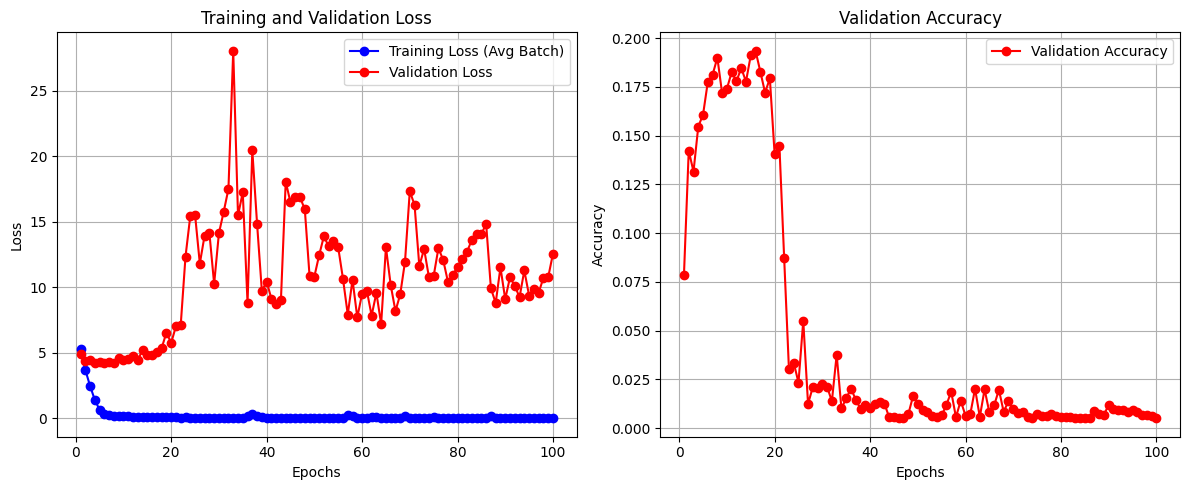

In [ ]:
# simple plotting using matplotlib if history was collected
if history['val_acc'] and any(v is not None for v in history['val_acc']):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss (Avg Batch)')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # skip plotting train_acc if it wasn't evaluated
    # plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy') 
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # save the plot
    plot_path = os.path.join(output_dir, "training_history.png")
    plt.savefig(plot_path)
    print(f"\nTraining history plot saved to {plot_path}")
    plt.show()
else:
    print("\nSkipping plotting (no validation data or history)." )